<a href="https://colab.research.google.com/github/hxiufan/709A2/blob/main/A2_Task3_LSTM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, avg, when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql.functions import desc, count

In [5]:
from pyspark.sql import Row

In [4]:
from statsmodels.graphics.tsaplots import plot_acf

In [6]:
# Mount my Google Drive
from google.colab import drive

In [7]:
# Initialize Spark session
spark = SparkSession.builder.appName("CommodityPricePrediction").getOrCreate()

In [8]:
# Load the dataset
data_path = '/content/drive/My Drive/DA709/kalimati_tarkari_dataset.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [ ]:
# Display the dataset
df.show()


+---+--------------------+----------+----+-------+-------+-------+
| SN|           Commodity|      Date|Unit|Minimum|Maximum|Average|
+---+--------------------+----------+----+-------+-------+-------+
|  0|  Tomato Big(Nepali)|2013-06-16|  Kg|   35.0|   40.0|   37.5|
|  1| Tomato Small(Local)|2013-06-16|  Kg|   26.0|   32.0|   29.0|
|  2|          Potato Red|2013-06-16|  Kg|   20.0|   21.0|   20.5|
|  3|        Potato White|2013-06-16|  Kg|   15.0|   16.0|   15.5|
|  4|  Onion Dry (Indian)|2013-06-16|  Kg|   28.0|   30.0|   29.0|
|  5|       Carrot(Local)|2013-06-16|  Kg|   30.0|   35.0|   32.5|
|  6|      Cabbage(Local)|2013-06-16|  Kg|    6.0|   10.0|    8.0|
|  7|         Cauli Local|2013-06-16|  Kg|   30.0|   35.0|   32.5|
|  8|         Raddish Red|2013-06-16|  Kg|   35.0|   40.0|   37.5|
|  9|Raddish White(Local)|2013-06-16|  Kg|   25.0|   30.0|   27.5|
| 10|        Brinjal Long|2013-06-16|  Kg|   16.0|   18.0|   17.0|
| 11|       Brinjal Round|2013-06-16|  Kg|   20.0|   22.0|   2

In [ ]:
# Display the shape of the dataset
print("Shape of the dataset:", (df.count(), len(df.columns)))

Shape of the dataset: (197161, 7)


In [9]:
# --- Data Preprocessing ---
# Convert 'Date' column to datetime and handle missing values
df = df.withColumn("Date", to_date(col("Date"), 'yyyy-MM-dd'))

In [10]:
df = df.na.drop()  # Drop rows with any missing values

In [11]:
# Detect and remove outliers based on the 'Average' price column (e.g., outside 3 standard deviations)
from pyspark.sql.functions import stddev  # Import stddev function
avg_price_stats = df.select(avg(col("Average")).alias("mean"), stddev(col("Average")).alias("stddev")).first()  # Use stddev function correctly
mean_price = avg_price_stats["mean"]
stddev_price = avg_price_stats["stddev"]

In [12]:
# Define upper and lower bounds for outlier detection
lower_bound = mean_price - 3 * stddev_price
upper_bound = mean_price + 3 * stddev_price

In [13]:
# Filter out outliers
df = df.filter((col("Average") >= lower_bound) & (col("Average") <= upper_bound))

Top 3 Commodities Trend Visualization

In [14]:
# Calculate average prices by commodity and date
average_prices = df.groupBy("Commodity", "Date").agg(avg("Average").alias("AveragePrice"))

In [15]:
# Get the top 3 commodities based on the number of records
top_commodities = df.groupBy("Commodity").count().orderBy(col("count").desc()).limit(3).select("Commodity").rdd.flatMap(lambda x: x).collect()

In [16]:
# Convert the filtered data to Pandas for visualization
trend_data = average_prices.filter(col("Commodity").isin(top_commodities)).toPandas()

In [ ]:
trend_data.head()

,Commodity,Date,AveragePrice
0,Cauli Local,2013-08-15,57.5
1,Ginger,2014-01-02,105.0
2,Cauli Local,2014-08-07,39.0
3,Cabbage(Local),2015-02-01,13.0
4,Cauli Local,2015-03-06,22.5


In [ ]:
# Apply a rolling average to smooth out fluctuations
trend_data['Date'] = pd.to_datetime(trend_data['Date'])
trend_data = trend_data.sort_values(by='Date')
# Calculate SmoothedPrice using transform to align index
trend_data['SmoothedPrice'] = trend_data.groupby('Commodity')['AveragePrice'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

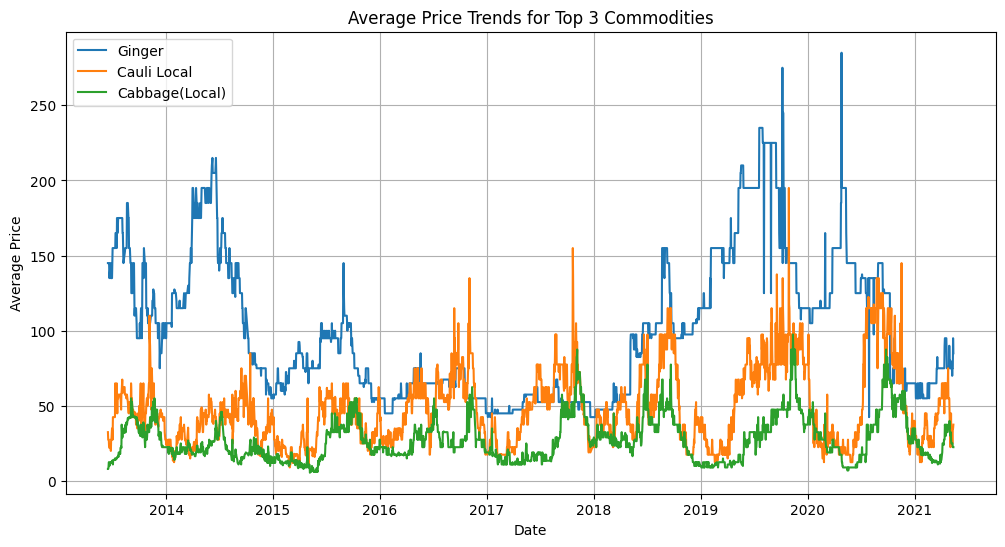

In [ ]:
# Plot the trends
plt.figure(figsize=(12, 6))
for commodity in top_commodities:
    subset = trend_data[trend_data['Commodity'] == commodity]
    plt.plot(subset['Date'], subset['AveragePrice'], label=commodity)

plt.title('Average Price Trends for Top 3 Commodities')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend()
plt.grid(True)
plt.show()

# Time Series Prediction for 'Ginger

In [ ]:
# Filter data for 'Ginger'
ginger_data = average_prices.filter(col("Commodity") == "Ginger").orderBy("Date")

In [ ]:
# Convert to Pandas DataFrame for LSTM training
ginger_df = ginger_data.toPandas()
ginger_df.set_index("Date", inplace=True)

In [ ]:
!pip install keras-tuner -q

In [ ]:
# Prepare data for LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from kerastuner.tuners import RandomSearch
from keras.optimizers import Adam

<ipython-input-14-f348bb84e5ba>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
import keras_tuner

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
ginger_scaled = scaler.fit_transform(ginger_df[['AveragePrice']])

In [ ]:
# Create sequences for LSTM
sequence_length = 30
X, y = [], []
for i in range(len(ginger_scaled) - sequence_length):
    X.append(ginger_scaled[i:i + sequence_length])
    y.append(ginger_scaled[i + sequence_length])

X, y = np.array(X), np.array(y)

In [ ]:
# Define a function to build the model for tuning
def build_model(hp):
    model = Sequential([
        LSTM(hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=True, input_shape=(X.shape[1], 1)),
        LSTM(hp.Int('units', min_value=32, max_value=128, step=32)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])), loss='mean_squared_error')
    return model

In [ ]:
# Perform hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='lstm_tuning_dir',
    project_name='lstm_hyperparameter_tuning'
)

tuner.search(X, y, epochs=10, validation_split=0.2)

Reloading Tuner from lstm_tuning_dir/lstm_hyperparameter_tuning/tuner0.json


In [ ]:
# Get the best model and evaluate it
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 0.0117 - val_loss: 0.0024
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 9.8133e-04 - val_loss: 0.0022
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0014 - val_loss: 0.0016


In [ ]:
# Evaluate the model's performance
from sklearn.metrics import mean_squared_error

# Make predictions on the training set
y_pred = model.predict(X)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_actual_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step


In [ ]:
# Calculate evaluation metrics
mse = mean_squared_error(y_actual_rescaled, y_pred_rescaled)
print(f"LSTM Model Mean Squared Error after Tuning: {mse:.2f}")

LSTM Model Mean Squared Error after Tuning: 62.27


# Before Hyperparameter Training

In [ ]:


# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model (Before hyperparameter training)
model.fit(X, y, epochs=10, batch_size=32)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0158
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0023
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0038
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0020
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0019
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0011
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0015
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0014
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0011
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0011


In [ ]:
# Evaluate the model's performance, before hyperparameter tuning
from sklearn.metrics import mean_squared_error

# Make predictions on the training set
y_pred = model.predict(X)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_actual_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(y_actual_rescaled, y_pred_rescaled)
print(f"LSTM Model Mean Squared Error: {mse:.2f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
LSTM Model Mean Squared Error: 68.31


# Classification task

In [17]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [18]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
from pyspark.ml.classification import GBTClassifier

In [19]:
# For Ramdon Forest model - Categorize prices into low, medium, high
df = df.withColumn("PriceCategory", when(col("Average") < 50, "Low")
                                      .when(col("Average") < 100, "Medium")
                                      .otherwise("High"))


In [ ]:
# For GBT
df = df.withColumn("PriceCategory", when(col("Average") < 50, 0)  # Low
                                      .otherwise(1))  # Not Low (Medium and High combined)

In [ ]:
df = df.withColumn("PriceCategory", when(col("Average") < 50, 0)  # Changed to 0
                                      .when(col("Average") < 100, 1) # Changed to 1
                                      .otherwise(2))  # Changed to 2, but still consider combining with 1 for binary classification

In [20]:
# Encode categorical features
indexer = StringIndexer(inputCol="PriceCategory", outputCol="label")
df = indexer.fit(df).transform(df)

In [21]:
# Assemble features
assembler = VectorAssembler(inputCols=["Minimum", "Maximum", "Average"], outputCol="features")
final_data = assembler.transform(df)

In [ ]:
# Rename 'PriceCategory' to 'label' for consistency
final_data = final_data.withColumnRenamed("PriceCategory", "label")

In [22]:
# Split data into training and testing sets
train_data, test_data = final_data.randomSplit([0.7, 0.3])

In [ ]:
# Define Random Forest model
#rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

In [24]:
rf = RandomForestClassifier(
    numTrees=50,  # Changed 'n_estimators' to 'numTrees'
    maxDepth=5,  # Changed 'max_depth' to 'maxDepth'
    minInstancesPerNode=10,  # Changed 'min_samples_split' to 'minInstancesPerNode'
    # class_weight is not available in Pyspark RandomForestClassifier
    #random_state=42  # 'random_state' is not supported in PySpark
    seed=42 # Changed 'random_state' to 'seed'
)

In [27]:
# Correct the fit method call by passing only the training data
rf_model = rf.fit(train_data)
y_pred = rf_model.transform(test_data) # Use transform for predictions on the test data


In [28]:
# Get the testing result
y_test = test_data.select("label").collect()
y_pred = y_pred.select("prediction").collect()

In [30]:
# print the testing result
print(y_test)
print(y_pred)


[Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=0.0), Row(label=1.0), Row(label=0.0), Row(label=0.0), Row(label=2.0), Row(label=1.0), Row(label=1.0), Row(label=2.0), Row(label=0.0), Row(label=0.0), Row(label=1.0), Row(label=1.0), Row(label=0.0), Row(label=0.0), Row(label=2.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=0.0), Row(label=0.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=2.0), Row(label=2.0), Row(label=1.0), Row(label=0.0), Row(label=0.0), Row(label=1.0), Row(label=1.0), Row(label=0.0), Row(label=2.0), Row(label=2.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=0.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=1.0), Row(label=2.0), Row(label=2.0), Row(lab

In [ ]:
print(classification_report(y_test, y_pred))

In [31]:
# Define a parameter grid for cross-validation
param_grid = ParamGridBuilder().addGrid(rf.numTrees, [50, 100, 150]).build()

In [32]:
# Define cross-validator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                          numFolds=5)

In [33]:
# Perform cross-validation
cv_model = crossval.fit(train_data)

In [34]:
# Make predictions
predictions = cv_model.transform(test_data)

In [35]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Random Forest Classification Accuracy with Cross-Validation: {accuracy:.2f}")

Random Forest Classification Accuracy with Cross-Validation: 1.00


In [36]:
# import r2 score related library
from pyspark.ml.evaluation import RegressionEvaluator

In [37]:
# Evaluate the model using appropriate metrics for classification
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Random Forest Classification Accuracy with Cross-Validation: {accuracy:.2f}")

# Calculate weighted precision
evaluator.setMetricName("weightedPrecision")
weighted_precision = evaluator.evaluate(predictions)
print(f"Random Forest Classification Weighted Precision: {weighted_precision:.2f}")

# Calculate weighted recall
evaluator.setMetricName("weightedRecall")
weighted_recall = evaluator.evaluate(predictions)
print(f"Random Forest Classification Weighted Recall: {weighted_recall:.2f}")

# Calculate F1 score
evaluator.setMetricName("f1")
f1_score = evaluator.evaluate(predictions)
print(f"Random Forest Classification F1 Score: {f1_score:.2f}")

Random Forest Classification Accuracy with Cross-Validation: 1.00
Random Forest Classification Weighted Precision: 1.00
Random Forest Classification Weighted Recall: 1.00
Random Forest Classification F1 Score: 1.00


In [ ]:
# GBT model

In [ ]:
# Define Gradient Boosted Trees model
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=100)

In [ ]:
# Define cross-validator for Gradient Boosted Trees
crossval_gbt = CrossValidator(estimator=gbt,
                               estimatorParamMaps=ParamGridBuilder().addGrid(gbt.maxIter, [50, 100]).build(),
                               evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                               numFolds=5)

In [ ]:
# Perform cross-validation for Gradient Boosted Trees
cv_model_gbt = crossval_gbt.fit(train_data)

In [ ]:
# Make predictions with Gradient Boosted Trees
predictions_gbt = cv_model_gbt.transform(test_data)

In [ ]:
# Evaluate the Gradient Boosted Trees model
gbt_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(predictions_gbt)
print(f"Gradient Boosted Trees Classification Accuracy with Cross-Validation: {gbt_accuracy:.2f}")

Gradient Boosted Trees Classification Accuracy with Cross-Validation: 1.00
